# Inference with parameter dependent signal yields

In this tutorial we will look into signal yields that depend on certain functional structure, e.g. depend on parameters $c_1$ and $c_2$. For this tutorial we will assume the following functional structure for signal yields:

$$
s(c_1, c_2) = 2.5 c_1^2 + 3.7  c_2^2
$$

Let us first install all the dependencies and functions that we will use in this tutorial.

In [6]:
import spey

import numpy as np
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from scipy.interpolate import griddata


def mesh2points(grid, npoints_tuple):
    ndim = len(npoints_tuple)
    X = np.moveaxis(grid, 0, ndim).reshape(int(np.product(npoints_tuple)), ndim)
    return X


def mgrid(rangedef):
    _rangedef = np.array(rangedef, dtype="complex128")
    slices = [slice(*_r) for _r in _rangedef]
    return np.mgrid[slices]


def values2mesh(values, rangedef, invalid, invalid_value=np.nan):
    grid = mgrid(rangedef)
    allX = mesh2points(grid, rangedef[:, 2])
    allv = values
    return allv.reshape(*map(int, rangedef[:, 2]))

Lets assume a bin with 3 observed yields, 3.6 background events and signal yields that depend on the function $s(c_1,c_2)$. One can include more than one bin but lets keep it simple.

In [28]:
data = [3]
background = [3.6]

def signal(c1, c2):
    return [2.5 * c1**2 + 3.7 * c2**2]

For simplisity we will use Poisson based likelihood which does not include background uncertainties

$$
\mathcal{L}(\mu) = \prod_{i\in{\rm bins}}{\rm Poiss}(n^i|\mu n_s^i + n_b^i)
$$

where $n$, $n_s$ and $n_b$ are observed, signal and background yields. Details on usage can be found in [this link](https://spey.readthedocs.io/en/main/plugins.html#default-pdf-poisson).

In [8]:
pdf_wrapper = spey.get_backend("default_pdf.poisson")

:::{note}
In order to see the documentation for the wrapper, one can use `?` syntax
```
pdf_wrapper?
```
:::

Let's compute $\chi^2$

$$
\chi^2 = -2\log\left(\frac{\mathcal{L}(\mu=1)}{\mathcal{L}(\hat\mu)}\right)
$$

$\hat\mu$ is the signal strength that maximises the likelihood. Note that since our signal is based on two variables, we can compute $\chi^2(c_1,c_2)$ as follows

In [17]:
chi2 = []
for c1 in np.linspace(-1, 1, 10):
    for c2 in np.linspace(-1, 1, 10):
        stat_model = pdf_wrapper(
            signal_yields=signal(c1, c2),
            background_yields=background,
            data=data,
            analysis="poisson",
        )
        chi2.append([c1, c2, stat_model.chi2()])
chi2 = np.array(chi2)

`chi2` contains the $\chi^2(c_1,c_2)$ values where $c_1, c_2 \in [-1,1]$. Note that we rather did a sparse scan over $c_1$ and $c_2$ values, in the following we will interpolate over these values using `griddata` function. The smoothness can be increased by increasing the number of points that we scaned through. For this example we only used 10 points for both parameters.

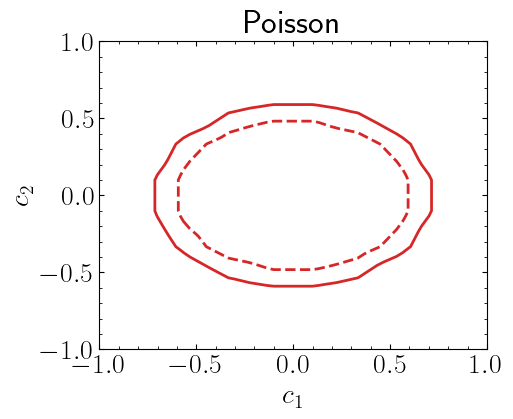

In [18]:
fig = plt.figure(figsize=(5, 4), facecolor=None, edgecolor="k")

plot_rangedef = np.array([[-1, 1, 61], [-1, 1, 61]])

truthv = griddata(
    (chi2[:, 0], chi2[:, 1]),
    chi2[:, 2],
    mesh2points(mgrid(plot_rangedef), plot_rangedef[:, 2]),
    method="linear",
)
truthv = values2mesh(truthv, plot_rangedef, False)
xv, yv = mgrid(plot_rangedef)

plt.contour(
    xv,
    yv,
    truthv,
    levels=[0.5, 0.8],
    colors=("tab:red",),
    linestyles=(
        "dashed",
        "solid",
    ),
    linewidths=(2,),
    zorder=10,
    alpha=1,
)
plt.title("Poisson")
plt.xlabel("$c_1$")
plt.ylabel("$c_2$")

plt.show()

## Including uncertainties

Instead of using simple Poisson likelihood, which does not include any uncertainty definition, one can also use uncorrelated background function which includes the uncertainties through serries of Gausian terms in the likelihood. For details see [this link](https://spey.readthedocs.io/en/main/plugins.html#default-pdf-uncorrelated-background).

Here we will define 6 observed yields and background is $10.6\pm4.8$.

In [19]:
data = [6]
background = [10.6]
bkg_unc = [4.8]

In the following we will create our PDF wrapper which includes the definition for uncorrelated backgrounds:

In [20]:
pdf_wrapper = spey.get_backend("default_pdf.uncorrelated_background")
# stat_model = pdf_wrapper?

As before, let us compute $\chi^2(c_1, c_2)$ in a similar fashion.

In [21]:
chi2 = []
for c1 in np.linspace(-1, 1, 10):
    for c2 in np.linspace(-1, 1, 10):
        stat_model_with_unc = pdf_wrapper(
            signal_yields=signal(c1, c2),
            background_yields=background,
            data=data,
            absolute_uncertainties=bkg_unc,
            analysis="with uncertainty",
        )
        chi2.append([c1, c2, stat_model_with_unc.chi2()])
chi2 = np.array(chi2)

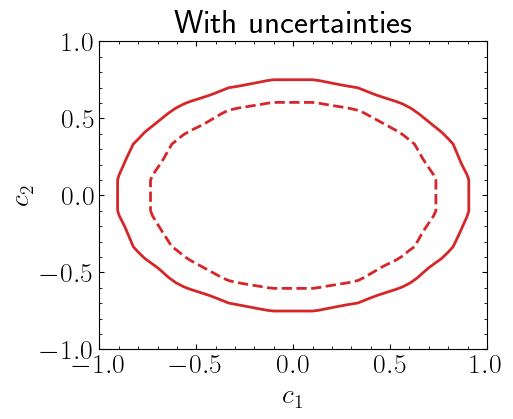

In [22]:
fig = plt.figure(figsize=(5, 4), facecolor=None, edgecolor="k")

plot_rangedef = np.array([[-1, 1, 61], [-1, 1, 61]])

truthv = griddata(
    (chi2[:, 0], chi2[:, 1]),
    chi2[:, 2],
    mesh2points(mgrid(plot_rangedef), plot_rangedef[:, 2]),
    method="linear",
)
truthv = values2mesh(truthv, plot_rangedef, False)
xv, yv = mgrid(plot_rangedef)

plt.contour(
    xv,
    yv,
    truthv,
    levels=[0.5, 0.8],
    colors=("tab:red",),
    linestyles=(
        "dashed",
        "solid",
    ),
    linewidths=(2,),
    zorder=10,
    alpha=1,
)
plt.title("With uncertainties")
plt.xlabel("$c_1$")
plt.ylabel("$c_2$")

plt.show()

## Combining likelihoods

Assuming these likelihoods are part of an uncorrelated histogram we can combine two likelihoods to build a more generic likelihood. For this, we will use [`UnCorrStatisticsCombiner`](https://spey.readthedocs.io/en/main/api.html#spey.UnCorrStatisticsCombiner).

As before, let us compute $\chi^2(c_1, c_2)$ but this time lets get this value for the combined likelihood.

In [26]:
chi2 = []
for c1 in np.linspace(-1, 1, 10):
    for c2 in np.linspace(-1, 1, 10):
        stat_model_with_unc = spey.get_backend("default_pdf.uncorrelated_background")(
            signal_yields=signal(c1, c2),
            background_yields=background,
            data=data,
            absolute_uncertainties=bkg_unc,
            analysis="with uncertainty",
        )
        stat_model = spey.get_backend("default_pdf.poisson")(
            signal_yields=signal(c1, c2),
            background_yields=background,
            data=data,
            analysis="poisson",
        )
        combined = spey.UnCorrStatisticsCombiner(stat_model, stat_model_with_unc)
        chi2.append([c1, c2, combined.chi2()])
chi2 = np.array(chi2)

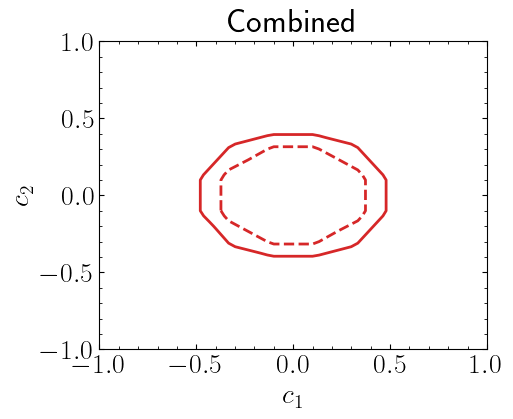

In [27]:
fig = plt.figure(figsize=(5, 4), facecolor=None, edgecolor="k")

plot_rangedef = np.array([[-1, 1, 61], [-1, 1, 61]])

truthv = griddata(
    (chi2[:, 0], chi2[:, 1]),
    chi2[:, 2],
    mesh2points(mgrid(plot_rangedef), plot_rangedef[:, 2]),
    method="linear",
)
truthv = values2mesh(truthv, plot_rangedef, False)
xv, yv = mgrid(plot_rangedef)

plt.contour(
    xv,
    yv,
    truthv,
    levels=[0.5, 0.8],
    colors=("tab:red",),
    linestyles=(
        "dashed",
        "solid",
    ),
    linewidths=(2,),
    zorder=10,
    alpha=1,
)

plt.title("Combined")
plt.xlabel("$c_1$")
plt.ylabel("$c_2$")
plt.show()

As can be seen, we can achieve much accurate representation of the sensitivity of our experiments to the theory by combining these likelihoods.